In [1]:
import os
import requests
import random
import math
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model, model_selection
from sklearn.utils import shuffle
import copy
import pandas as pd

import torch
import torch.nn.functional as F
from torch import nn
from torch.nn.utils import prune
from torch import optim
from torch.utils.data import DataLoader, TensorDataset

import torchvision
from torchvision import transforms
from torchvision.utils import make_grid
from torchvision.models import resnet18
from torchvision.models.feature_extraction import create_feature_extractor

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device:", DEVICE.upper())

# manual random seed is used for dataset partitioning
# to ensure reproducible results across runs
SEED = 42
RNG = torch.Generator().manual_seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)

import sys
sys.path.append('../')
from utils import *

Running on device: CUDA


In [2]:
import ssl

# Create an unverified SSL context
ssl._create_default_https_context = ssl._create_unverified_context

In [34]:
batch_size = 512

In [35]:
# download and pre-process CIFAR10
normalize = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ]
)

train_set = torchvision.datasets.CIFAR10(
    root="../example notebooks/data", train=True, download=False, transform=normalize
)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=1)

# we split held out data into test and validation set
held_out = torchvision.datasets.CIFAR10(
    root="../example notebooks/data", train=False, download=False, transform=normalize
)
test_set, val_set = torch.utils.data.random_split(held_out, [0.5, 0.5], generator=RNG)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=True, num_workers=1)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=1)

# download the forget and retain index split
local_path = "../example notebooks/forget_idx.npy"
# if not os.path.exists(local_path):
#     response = requests.get(
#         "https://storage.googleapis.com/unlearning-challenge/" + local_path
#     )
#     open(local_path, "wb").write(response.content)
forget_idx = np.load(local_path)

# construct indices of retain from those of the forget set
forget_mask = np.zeros(len(train_set.targets), dtype=bool)
forget_mask[forget_idx] = True
retain_idx = np.arange(forget_mask.size)[~forget_mask]

# split train set into a forget and a retain set
forget_set = torch.utils.data.Subset(train_set, forget_idx)
retain_set = torch.utils.data.Subset(train_set, retain_idx)

forget_loader = torch.utils.data.DataLoader(
    forget_set, batch_size=batch_size, shuffle=True, num_workers=1
)
# retain_loader = torch.utils.data.DataLoader(
#     retain_set, batch_size=128, shuffle=True, num_workers=1, generator=RNG
# )

In [36]:
retain_loader = torch.utils.data.DataLoader(
    retain_set, batch_size=batch_size, shuffle=True, num_workers=1
)

- Retain set accuracy: 99.5%
- Forget set accuracy: 99.3%
- Val set accuracy: 88.9%
- Test set accuracy: 88.3%

In [37]:
local_path = "../example notebooks/weights/weights_resnet18_cifar10.pth"
if not os.path.exists(local_path):
    response = requests.get(
        "https://storage.googleapis.com/unlearning-challenge/weights_resnet18_cifar10.pth"
    )
    open(local_path, "wb").write(response.content)

weights_pretrained = torch.load(local_path, map_location=DEVICE) #43Mbs

# load net with pre-trained weights
net = resnet18(weights=None, num_classes=10)
net.load_state_dict(weights_pretrained)
net.to(DEVICE)
net.eval();

In [38]:
# Contrastive Loss
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin
    
    def forward(self, output1, output2, label):
        euclidean_distance = nn.functional.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) + (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        return loss_contrastive

In [39]:
val_losses = compute_losses(net, val_loader)

# test_losses = compute_losses(net, test_loader)

In [40]:
# Extract feature and pooling layers to create a Custom Model
class CustomResNet18(nn.Module):
    def __init__(self, original_model):
        super(CustomResNet18, self).__init__()
        
        # Extract features and pooling layers
        self.features = nn.Sequential(*list(original_model.children())[:-2])
        self.pooling = list(original_model.children())[-2]
    
    def forward(self, x):
        x = self.features(x)
        x = self.pooling(x)
        x = torch.squeeze(x)
        return x

custom_model = CustomResNet18(net).to(DEVICE)

In [41]:
def get_embeddings(
    net, 
    retain_loader,
    val_loader
):
    
    '''
    Feature extraction
    '''
    
    feat_extractor = create_feature_extractor(net, {'avgpool': 'feat1'})
    
    '''
    Get class weights
    '''
    
    # Retain logits
    data = np.empty((len(retain_loader.dataset), 513), dtype=object)
    idx = 0
    
    with torch.no_grad():
        for sample in retain_loader:
            # Get logits
            targets = sample[1]
            
            # Feature extraction
            inputs = sample[0]
            person_id = sample[1]
            outputs = feat_extractor(inputs.to(DEVICE))['feat1']
            feats = torch.flatten(outputs, start_dim=1)
        
            for i in range(len(targets)):
                data[idx] = [targets[i].item()] + feats[i].cpu().numpy().tolist()
                idx +=1
       
    columns = ['unique_id'] + [f'feat_{i}' for i in range(512)]
    embeddings_retain_df = pd.DataFrame(data, columns=columns)
    

    # Val logits
    data = np.empty((len(val_loader.dataset), 513), dtype=object)
    idx = 0
    
    with torch.no_grad():
        for sample in val_loader:
            # Get logits
            targets = sample[1]
            
            # Feature extraction
            inputs = sample[0]
            person_id = sample[1]
            outputs = feat_extractor(inputs.to(DEVICE))['feat1']
            feats = torch.flatten(outputs, start_dim=1)
        
            for i in range(len(targets)):
                data[idx] = [str(person_id[i].item())+'a'] + feats[i].cpu().numpy().tolist()
                idx +=1

    columns = ['unique_id'] + [f'feat_{i}' for i in range(512)]
    embeddings_val_df = pd.DataFrame(data, columns=columns)
    

    return embeddings_retain_df, embeddings_val_df

In [42]:
embeddings_retain_df, embeddings_val_df = get_embeddings(net, retain_loader, val_loader)

In [43]:
# Pre-group embeddings by unique_id for fast lookup
grouped_val_df = embeddings_val_df.groupby('unique_id').apply(lambda x: x.iloc[:, 1:].values)
grouped_retain_df = embeddings_retain_df.groupby('unique_id').apply(lambda x: x.iloc[:, 1:].values)

In [44]:
def contrastive_unlearning(net, forget_loader, grouped_retain_df, grouped_val_df, LR=1e-3, max_num_steps=3):
    
    custom_model = CustomResNet18(net).to(DEVICE)
    criterion = ContrastiveLoss()
    optimizer = optim.AdamW(custom_model.parameters(), lr=LR)
    
    warmup_current_batch = 0
    warmup_batches = math.ceil(1*len(forget_loader.dataset))
    
    for i, batch in enumerate(forget_loader):
        custom_model.train()
        optimizer.zero_grad()
        inputs = batch[0].to(DEVICE)
        targets = batch[1]
        person_ids = batch[1]

        # Forward pass to get embeddings for the forget_batch
        forget_embeddings = custom_model(inputs)

        positive_pairs = []
        negative_pairs = []

        with torch.no_grad():  # Disable gradient computation to save memory
            
            # Fetch Positive Pairs
            for index, pid in enumerate(person_ids):
                candidate_embeddings = grouped_val_df.get(str(pid), None)
                if candidate_embeddings is not None:  # If a positive pair exists
                    selected_embedding = shuffle(candidate_embeddings, n_samples=1)[0]  # Randomly select one
                else:  # Fallback to using the instance's own embedding
                    selected_embedding = forget_embeddings[index].cpu().detach().numpy()

                positive_pairs.append(torch.tensor(selected_embedding.astype(float)).float())


            # Convert to tensors for ease of computation
            positive_pairs = torch.stack(positive_pairs).to(DEVICE)

            # Fetch Negative Pairs
            for tgt in targets.cpu().numpy():
                candidate_embeddings = grouped_retain_df.get(tgt, None)
                if candidate_embeddings is not None:
                    selected_embedding = shuffle(candidate_embeddings, n_samples=1)[0]  # Randomly select one
                    negative_pairs.append(torch.tensor(selected_embedding.astype(float)).float())
                else:
                    break


            # Convert to tensors for ease of computation
            negative_pairs = torch.stack(negative_pairs).to(DEVICE)

        # Compute Contrastive Loss
        positive_loss = criterion(forget_embeddings, positive_pairs, torch.zeros(positive_pairs.shape[0]).to(DEVICE))
        negative_loss = criterion(forget_embeddings, negative_pairs, torch.ones(negative_pairs.shape[0]).to(DEVICE))

        # warmup_current_batch += 1

        # # Warm-up for the first 'warmup_batches' batches
        # if warmup_current_batch <= warmup_batches:
        #     adjust_learning_rate(optimizer, warmup_current_batch, warmup_batches, LR)
        
        
        # Total loss
        loss = positive_loss # + negative_loss

        loss.backward()
        optimizer.step()
        
        if i==max_num_steps:
            break

In [45]:
contrastive_unlearning(net, forget_loader, grouped_retain_df, grouped_val_df, LR=1e-4, max_num_steps=10)

In [46]:
def unlearning(net, retain, forget, validation):
    """Unlearning by fine-tuning.

    Fine-tuning is a very simple algorithm that trains using only
    the retain set.

    Args:
      net : nn.Module.
        pre-trained model to use as base of unlearning.
      retain : torch.utils.data.DataLoader.
        Dataset loader for access to the retain set. This is the subset
        of the training set that we don't want to forget.
      forget : torch.utils.data.DataLoader.
        Dataset loader for access to the forget set. This is the subset
        of the training set that we want to forget. This method doesn't
        make use of the forget set.
      validation : torch.utils.data.DataLoader.
        Dataset loader for access to the validation set. This method doesn't
        make use of the validation set.
    Returns:
      net : updated model
    """
    epochs = 1

    net.fc.requires_grad_(False)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    net.train()

    for _ in range(epochs):
        for inputs, targets in retain:
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
        scheduler.step()

    net.eval()
    return net

In [47]:
# # Apply pruning
# pct = 0.25
# unstructure_prune(net, pct, global_pruning=True, random_init=True)

In [48]:
# net = unlearning(net, retain_loader, forget_loader, val_loader)

Forget set accuracy: 67.38%
Test set accuracy: 60.40%
--------------------


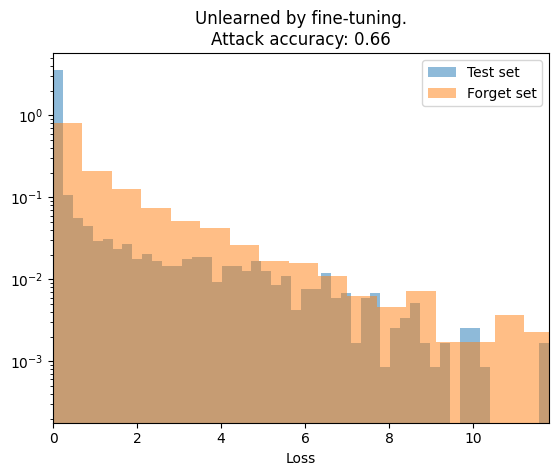

In [49]:
with torch.no_grad():
    net.eval()
    forget_acc = accuracy(net, forget_loader)
    test_acc = accuracy(net, test_loader)
print(f"Forget set accuracy: {100.0 * forget_acc:0.2f}%")
print(f"Test set accuracy: {100.0 * test_acc:0.2f}%")
print('--'*10)

ft_forget_losses = compute_losses(net, forget_loader)

ft_mia_scores = calc_mia_acc(ft_forget_losses, val_losses)

fig = plt.Figure(figsize=(16, 6))

plt.title(
    f"Unlearned by fine-tuning.\nAttack accuracy: {ft_mia_scores.mean():0.2f}"
)
plt.hist(val_losses, density=True, alpha=0.5, bins=50, label="Test set")
plt.hist(ft_forget_losses, density=True, alpha=0.5, bins=50, label="Forget set")

plt.xlabel("Loss")
plt.yscale("log")
plt.xlim((0, np.max(val_losses)))
plt.legend()

plt.show()

In [50]:
import sys
sys.exit()

SystemExit: 

C:\Users\luis.pinto1\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py:3441: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [ ]:
def retrain_step(net, retain_loader, steps):

    initial_retain_lr = 0.1
    criterion = nn.CrossEntropyLoss()
    optimizer_retain = optim.SGD(net.parameters(), lr=initial_retain_lr, momentum=0.9, weight_decay=5e-4)

    warmup_current_batch = 0
    warmup_batches = math.ceil(0.5*len(retain_loader.dataset))
    
    net.train()

    for counter, sample in enumerate(retain_loader):

        inputs, targets = sample
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

        warmup_current_batch += 1

        # Warm-up for the first 'warmup_batches' batches
        # if warmup_current_batch <= warmup_batches:
        #     adjust_learning_rate(optimizer_retain, warmup_current_batch, warmup_batches, initial_retain_lr)

        optimizer_retain.zero_grad()

        # Forward pass
        logits = net(inputs)

        # Calculate loss
        criterion = nn.CrossEntropyLoss(label_smoothing=0.0)
        classification_loss = criterion(logits, targets)
        loss = classification_loss
        loss.backward()
        optimizer_retain.step()

        if counter==steps:
            break

    # torch.save({
    #     'net': net.state_dict(),
    # }, f'./checkpoints/temp_checkpoint.pth')

    return net

In [ ]:
net = retrain_step(net, retain_loader, steps=len(retain_loader.dataset))

In [ ]:
with torch.no_grad():
    net.eval()
    forget_acc = accuracy(net, forget_loader)
    test_acc = accuracy(net, test_loader)
print(f"Forget set accuracy: {100.0 * forget_acc:0.2f}%")
print(f"Test set accuracy: {100.0 * test_acc:0.2f}%")
print('--'*10)

ft_forget_losses = compute_losses(net, forget_loader)

ft_mia_scores = calc_mia_acc(ft_forget_losses, val_losses)

fig = plt.Figure(figsize=(16, 6))

plt.title(
    f"Unlearned by fine-tuning.\nAttack accuracy: {ft_mia_scores.mean():0.2f}"
)
plt.hist(val_losses, density=True, alpha=0.5, bins=50, label="Test set")
plt.hist(ft_forget_losses, density=True, alpha=0.5, bins=50, label="Forget set")

plt.xlabel("Loss")
plt.yscale("log")
plt.xlim((0, np.max(val_losses)))
plt.legend()

plt.show()

In [ ]:


criterion = ContrastiveLoss()
LR = 1e-3
optimizer = optim.AdamW(custom_model.parameters(), lr=LR)

warmup_current_batch = 0
warmup_batches = math.ceil(1*len(forget_loader.dataset))

for x in range(3):
    for i, batch in enumerate(forget_loader):
        custom_model.train()
        optimizer.zero_grad()
        
        inputs = batch[0].to(DEVICE)
        targets = batch[1]
        person_ids = batch[1]
        
        # Forward pass to get embeddings for the forget_batch
        forget_embeddings = custom_model(inputs)
        
        positive_pairs = []
        negative_pairs = []

        with torch.no_grad():  # Disable gradient computation to save memory
            
            # Fetch Positive Pairs
            for index, pid in enumerate(person_ids.cpu().numpy()):
                candidate_embeddings = grouped_val_df.get(str(pid)+'a', None)
                if candidate_embeddings is not None:  # If a positive pair exists
                    selected_embedding = shuffle(candidate_embeddings, n_samples=1)[0]  # Randomly select one
                else:  # Fallback to using the instance's own embedding
                    selected_embedding = forget_embeddings[index].cpu().detach().numpy()

                positive_pairs.append(torch.tensor(selected_embedding.astype(float)).float())
            # Convert to tensors for ease of computation
            positive_pairs = torch.stack(positive_pairs).to(DEVICE)


            # Fetch Negative Pairs
            for tgt in targets.cpu().numpy():
                candidate_embeddings = grouped_retain_df.get(tgt, None)
                if candidate_embeddings is not None:
                    selected_embedding = shuffle(candidate_embeddings, n_samples=1)[0]  # Randomly select one
                    negative_pairs.append(torch.tensor(selected_embedding.astype(float)).float())
                else:
                    break
            # Convert to tensors for ease of computation
            negative_pairs = torch.stack(negative_pairs).to(DEVICE)
        

        # Compute Contrastive Loss
        positive_loss = criterion(forget_embeddings, positive_pairs, torch.zeros(positive_pairs.shape[0]).to(DEVICE))
        # print(f'Positive loss: {positive_loss}')
        negative_loss = criterion(forget_embeddings, negative_pairs, torch.ones(negative_pairs.shape[0]).to(DEVICE))
        # print(f'Neg loss: {negative_loss}')

        warmup_current_batch += 1

        # Warm-up for the first 'warmup_batches' batches
        if warmup_current_batch <= warmup_batches:
            adjust_learning_rate(optimizer, warmup_current_batch, warmup_batches, LR)

        # Total loss
        loss = positive_loss + negative_loss

        loss.backward()
        optimizer.step()

    #     if i==5:
    #         # print('END')
    #         break

    LR = 1e-3
    net = retrain_step(net, retain_loader, steps=len(retain_loader.dataset))


    with torch.no_grad():
        net.eval()
        forget_acc = accuracy(net, forget_loader)
        test_acc = accuracy(net, test_loader)
    print(f"Forget set accuracy: {100.0 * forget_acc:0.2f}%")
    print(f"Test set accuracy: {100.0 * test_acc:0.2f}%")
    print('--'*10)

    ft_forget_losses = compute_losses(net, forget_loader)

    ft_mia_scores = calc_mia_acc(ft_forget_losses, val_losses)

    fig = plt.Figure(figsize=(16, 6))

    plt.title(
        f"Unlearned by fine-tuning.\nAttack accuracy: {ft_mia_scores.mean():0.2f}"
    )
    plt.hist(val_losses, density=True, alpha=0.5, bins=50, label="Test set")
    plt.hist(ft_forget_losses, density=True, alpha=0.5, bins=50, label="Forget set")

    plt.xlabel("Loss")
    plt.yscale("log")
    plt.xlim((0, np.max(val_losses)))
    plt.legend()

    plt.show()

In [ ]:
print(accuracy(net, forget_loader))
print(accuracy(net, val_loader))
print(accuracy(net, test_loader))